In [75]:
import tensorflow as tf
import numpy as np
import pandas as pd
from random import sample, shuffle
from sklearn import preprocessing
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import layers, models, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [30]:
'''
Data Source:
https://www.kaggle.com/datasets/kundanbedmutha/exam-score-prediction-dataset?resource=download
'''
exam_score_data = pd.read_csv(r'D:\Python things\middle-ml-cv-roadmap\data\raw\Exam_Score_Prediction.csv', sep=',')

In [33]:
exam_score_data.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [35]:
exam_score_data.dtypes

student_id            int64
age                   int64
gender               object
course               object
study_hours         float64
class_attendance    float64
internet_access      object
sleep_hours         float64
sleep_quality        object
study_method         object
facility_rating      object
exam_difficulty      object
exam_score          float64
dtype: object

In [32]:
exam_score_data.describe()

,student_id,age,study_hours,class_attendance,sleep_hours,exam_score
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,10000.504600,20.473300,4.007604,70.017365,7.00856,62.513225
std,5773.654959,2.284458,2.308313,17.282262,1.73209,18.908491
min,1.000000,17.000000,0.080000,40.600000,4.10000,19.599000
25%,5000.750000,18.000000,2.000000,55.100000,5.50000,48.800000
50%,10000.500000,20.000000,4.040000,69.900000,7.00000,62.600000
75%,15000.250000,22.000000,6.000000,85.000000,8.50000,76.300000
max,20001.000000,24.000000,7.910000,99.400000,9.90000,100.000000


In [38]:
# Selecting features and target
# Features: age, study_hours, class_attendance, sleep_hours
# Target: exam_score (0<75 otherwise 1)
raw_data = exam_score_data[['age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']].copy()
raw_data['exam_score'] = np.where(raw_data['exam_score'] < 75, 0, 1)
raw_data.head()

,age,study_hours,class_attendance,sleep_hours,exam_score
0,17,2.78,92.9,7.4,0
1,23,3.37,64.8,4.6,0
2,22,7.88,76.8,8.5,1
3,20,0.67,48.4,5.8,0
4,20,0.89,71.6,9.8,0


In [41]:
# Balance the dataset
total_observations = len(raw_data)
num_one_targets = int(raw_data['exam_score'].sum())
num_zero_targets = total_observations - num_one_targets
num_ind_drop = num_zero_targets - num_one_targets
num_zero_ind = raw_data[raw_data['exam_score'] == 0].index.to_list()

indices_to_remove = sample(num_zero_ind, num_ind_drop)
balanced_data = raw_data.copy()
balanced_data = balanced_data.drop(index=indices_to_remove)
balanced_data = balanced_data.reset_index(drop=True)

print(balanced_data[balanced_data['exam_score'] == 1]['exam_score'].count())
print(balanced_data[balanced_data['exam_score'] == 0]['exam_score'].count())

5453
5453


In [48]:
# Shuffle the data
shuffled_indices = np.arange(balanced_data.shape[0])
np.random.shuffle(shuffled_indices)

# Use the shuffled indices to shuffle the inputs and targets.
shuffled_df = balanced_data.loc[shuffled_indices]
shuffled_df = shuffled_df.reset_index(drop=True)

In [49]:
# Set inputs and targets
unscaled_inputs_all = np.array(shuffled_df.iloc[:,:-1])

# The targets are in the last column. That's how datasets are conventionally organized.
targets_all = np.array(shuffled_df.iloc[:,-1])

In [50]:
# Standardize the inputs
scaler = preprocessing.StandardScaler()
scaler.fit(unscaled_inputs_all)
scaled_inputs = scaler.transform(unscaled_inputs_all)

with open(r'D:\Python things\middle-ml-cv-roadmap\models\ExamPassingPrediction_roadmap_Day_3.XGBClassifier_scaler', 'wb') as file:
    pickle.dump(scaler, file)

In [56]:
samples_count = scaled_inputs.shape[0]
# # Count the samples in each subset, assuming we want 90-10 distribution of training and test.
train_samples_count = int(0.9 * samples_count)
test_samples_count = samples_count - train_samples_count

train_inputs = scaled_inputs[:train_samples_count]
train_targets = targets_all[:train_samples_count]

test_inputs = scaled_inputs[train_samples_count:]
test_targets = targets_all[train_samples_count:]

In [61]:
# Split the train dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    train_inputs,
    train_targets,
    test_size=0.1,
    random_state=42,
    stratify=train_targets)    # keep class proportions (classification)

In [63]:
inputs = layers.Input(shape=(4,))
x = layers.Dense(128, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"])

early_stop = EarlyStopping(
    monitor="val_loss",       # what to monitor
    patience=3,               # epochs to wait without improvement
    restore_best_weights=True)# roll back to best epoch

checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",
    save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    # callbacks=[early_stop, checkpoint],
    verbose=2)

Epoch 1/100
139/139 - 1s - 9ms/step - accuracy: 0.7980 - loss: 0.4452 - val_accuracy: 0.8208 - val_loss: 0.3986
Epoch 2/100
139/139 - 0s - 2ms/step - accuracy: 0.8066 - loss: 0.4113 - val_accuracy: 0.8248 - val_loss: 0.3964
Epoch 3/100
139/139 - 0s - 2ms/step - accuracy: 0.8083 - loss: 0.4091 - val_accuracy: 0.8248 - val_loss: 0.3942
Epoch 4/100
139/139 - 0s - 2ms/step - accuracy: 0.8066 - loss: 0.4097 - val_accuracy: 0.8208 - val_loss: 0.3941
Epoch 5/100
139/139 - 0s - 2ms/step - accuracy: 0.8065 - loss: 0.4084 - val_accuracy: 0.8238 - val_loss: 0.3936
Epoch 6/100
139/139 - 0s - 2ms/step - accuracy: 0.8087 - loss: 0.4079 - val_accuracy: 0.8238 - val_loss: 0.3916
Epoch 7/100
139/139 - 0s - 2ms/step - accuracy: 0.8086 - loss: 0.4076 - val_accuracy: 0.8228 - val_loss: 0.3926
Epoch 8/100
139/139 - 0s - 2ms/step - accuracy: 0.8070 - loss: 0.4101 - val_accuracy: 0.8228 - val_loss: 0.3971
Epoch 9/100
139/139 - 0s - 2ms/step - accuracy: 0.8100 - loss: 0.4073 - val_accuracy: 0.8198 - val_loss:

In [70]:
def plot_history(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.

    Args:
        history (dict): The history.history dictionary returned by model.fit().
    """

    # Determine which keys to use for loss and accuracy
    # Keras uses 'accuracy'/'val_accuracy' or 'acc'/'val_acc'
    if 'accuracy' in history:
        acc_key = 'accuracy'
        val_acc_key = 'val_accuracy'
    elif 'acc' in history:
        acc_key = 'acc'
        val_acc_key = 'val_acc'
    else:
        print("Could not find accuracy/acc keys in history.")
        return

    # Get the number of epochs
    epochs = range(1, len(history['loss']) + 1)
    
    # 1. Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history[acc_key], 'b', label='Training Accuracy')
    plt.plot(epochs, history[val_acc_key], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout() # Adjusts plot to prevent overlap
    plt.show()

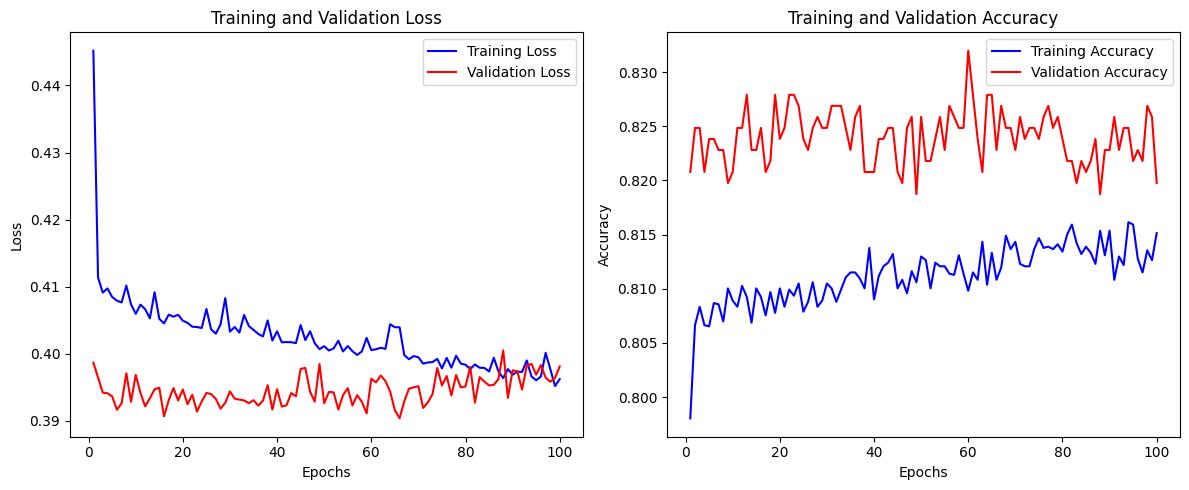

In [71]:
plot_history(history.history)

In [73]:
predicted_labels = model.predict(test_inputs)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [81]:
accuracy = accuracy_score(test_targets, (predicted_labels.reshape(-1) > 0.5).astype(int))

In [82]:
print("Accuracy:", accuracy)

Accuracy: 0.8130155820348305
